### Imports and project setup

In [177]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pytest # better asserts
from tensorflow import keras # neural network class
from tensorflow.keras import layers # neural network layers
from sklearn.impute import SimpleImputer #imputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder # for handling categorical columns
from sklearn.model_selection import train_test_split # to partition data into train and val
from sklearn.compose import make_column_transformer # preprocessing
from sklearn.pipeline import make_pipeline # pipelines

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

print("Setup Complete.")

Setup Complete.


### Reading the data

In [178]:
data_train = pd.read_csv("./train.csv", index_col=0)
data_test = pd.read_csv("./test.csv", index_col=0)

X = data_train.copy()
y = X.pop('Survived')

print(X.shape)
X.head()

(891, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Investigating the Data 

In [ ]:
data_train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [ ]:
data_train.select_dtypes(exclude='number').nunique(axis=0, dropna=True)

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [194]:
data_test.select_dtypes(exclude='number').nunique(axis=0, dropna=False)

Name        418
Sex           2
Ticket      363
Cabin        77
Embarked      3
dtype: int64

### Preprocessing the data

In [195]:
features_num = [col for col in X.columns if X[col].dtype in ['int64','float64']]
    # automatically add numerical columns here
assert features_num == ["Pclass", "Age", "SibSp", "Parch","Fare"]

features_cat = [col for col in X.columns if X[col].dtype == 'object' and 
                                                X[col].nunique() <= 10
]   # manually add catgorical columns here or automate it  
assert features_cat == ['Sex', 'Embarked']

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# Create the train/valid split
X_train, X_valid, y_train, y_valid =  \
    train_test_split(X, y, stratify=y, train_size = 0.8, random_state=3, )
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print(input_shape)

[11]


### Setting up the neural network

In [196]:
# neural network definition
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # layers.Input(shape=(None,input_shape)),
    layers.BatchNormalization(input_shape=input_shape),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation='sigmoid'),
])

C:\Users\manue\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [197]:
# compiling
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

### Learning the train set and validating

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - binary_accuracy: 0.5156 - loss: 0.8893 - val_binary_accuracy: 0.7207 - val_loss: 0.6414
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6605 - loss: 0.6789 - val_binary_accuracy: 0.7430 - val_loss: 0.5938
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7103 - loss: 0.6550 - val_binary_accuracy: 0.7821 - val_loss: 0.5602
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7432 - loss: 0.5681 - val_binary_accuracy: 0.8045 - val_loss: 0.5305
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7536 - loss: 0.5287 - val_binary_accuracy: 0.8101 - val_loss: 0.5000
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7444 - loss: 0.5420 - val_binary_accuracy: 0.8156 - val_loss: 0.4804
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7844 - loss: 0.5244 - val_binary_accuracy: 0.8324 - val_loss: 0.4634
Epoch 8/200


<Axes: title={'center': 'Accuracy'}>

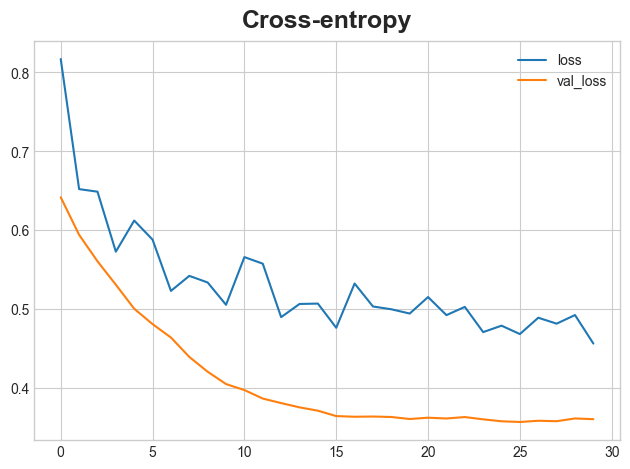

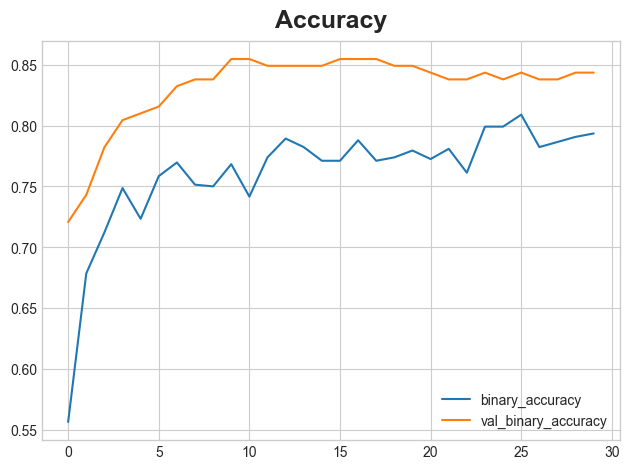

In [198]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=200,
    callbacks=[early_stopping],
)


# Plotting the learning process
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### Applying the model to the test data

In [206]:
print(X_train.shape)
print(data_test.shape)
processed_test = preprocessor.transform(data_test)
print(processed_test.shape)
np.isnan(processed_test).map(any)


In [201]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
test_predictions = my_pipeline.predict(data_test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

### To-do list:
1. Running the model on the test data and computing the accuracy
